In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%reload_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import sys
sys.path.append('../src')

import colorsys
from copy import deepcopy
import cv2
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pickle
# import pyclesperanto_prototype as cle
import re
from scipy.stats import norm
from skimage import restoration
import tifffile as tiff
from time import time
from tqdm import tqdm

from utils import list_subdir_filter as lsd#, flatten, local_normalization
from metadata import metadata

In [4]:
md = metadata()
img_files =  lsd(md.folders['bg_removed'], True, '\.npy')
out = os.path.join(md.folders['illumination'], 'illumination_profile')
Path(out).mkdir(exist_ok=True, parents=True)
markers = md.markers

textargs=dict(
    x=0.05, 
    y=0.95,
    horizontalalignment='left',
    verticalalignment='top', 
    fontsize=10,
    c='black',
    weight='normal'
)

img_type = 'uint8'

# cle.available_device_names()


### Load data

First we get all raw images for the selected slides, one by one we load them and extract the vertical and horizontal illumination profiles, which are stored in a pickle file

In [6]:
for img_file in tqdm(img_files):
    tissue_id =re.sub('.*A40\.([0-9]{4}).*$', '\\1', img_file)

    if not os.path.exists(os.path.join(out, f'A40_{tissue_id}_profiles.pickle')):
        #print(f'slide {slide} - dot {dot} / {md.slides_ndots[slide]}')
        img = np.load(img_file)#np.array([tiff.imread(r) for r in filenames]))
        horiz = np.median(img, axis=-2)
        vert = np.median(img, axis=-1)
        pickle.dump({'h':horiz, 'v':vert}, open(os.path.join(out, f'A40_{tissue_id}_profiles.pickle'), 'wb'))
        

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [1:18:04<00:00, 212.95s/it]


Once we are done we just load all illumination profiles together and create two arrays, one for the horizontal profiles and one for the vertical profiles

In [2]:
profiles = [pickle.load(open(p, 'rb')) for p in list_subdir_filter(out, False, 'profiles.pickle')]

horiz, vert = np.array([p['h'] for p in profiles]), np.array([p['v'] for p in profiles])
img_side = np.shape(horiz)[-1]

ndots = [md.slides_ndots['525'], md.slides_ndots['526'], md.slides_ndots['527']]
ndots_cumulative = np.cumsum([0] + ndots)
line_colors = ['deeppink', 'limegreen', 'mediumslateblue']

NameError: name 'list_subdir_filter' is not defined

### Plots
First thing first, a straightforward plot of the horizontal projections. Notice how some channels have more background than signal :(())

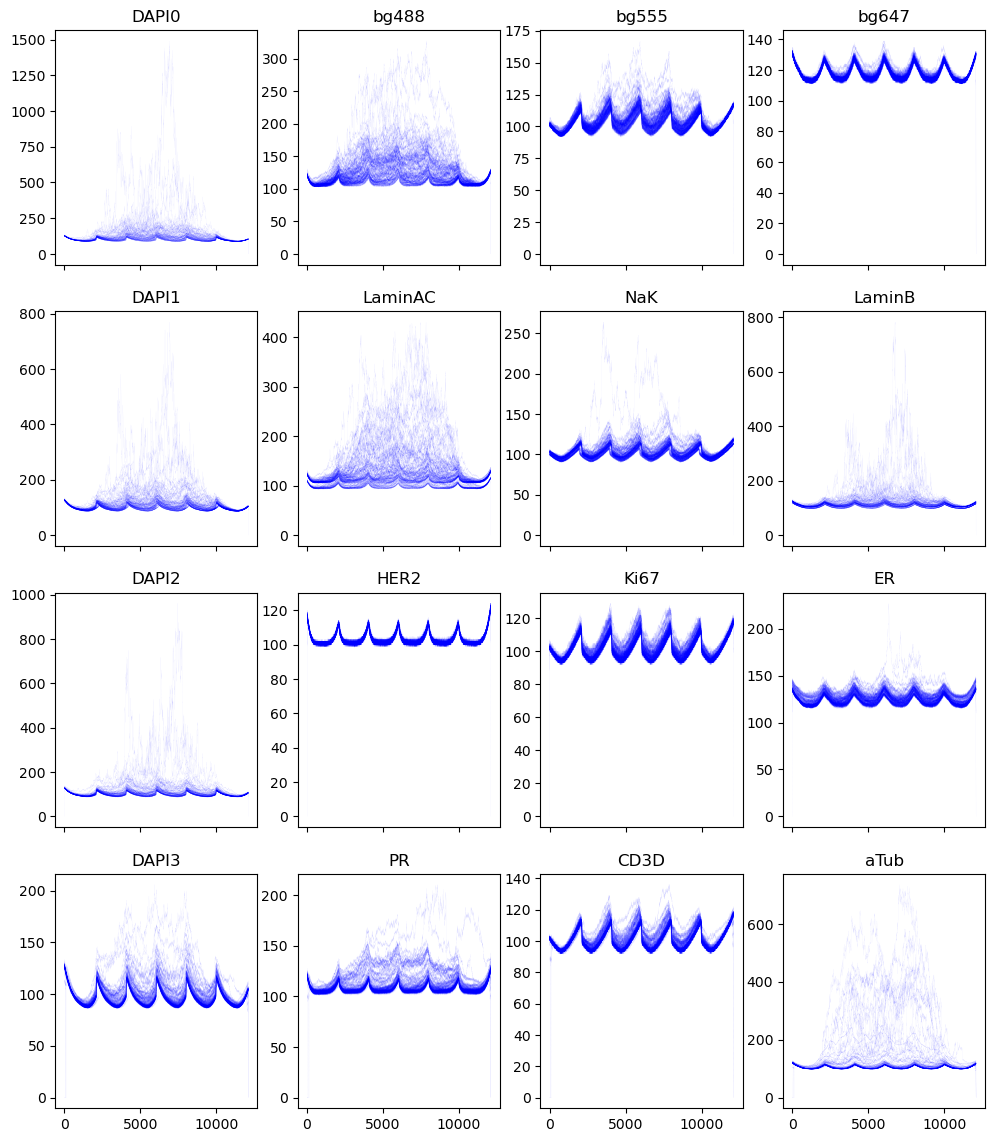

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,14), sharex=True, sharey=False)
for i, ax in enumerate(axes.ravel()):
    for j in range(len(horiz)):
        ax.plot(horiz[j, i, :], alpha=0.2, linewidth=.05, c='blue')
    ax.set_title(markers[i])

Hold on... why is the signal for the background channels so much louder than the signal of actual markers?!?!

The following plot is the same as above but we now mark the minimum value of all projections, pixel by pixel, in red, and a sort of "minimum threshold"' in black.
This is simply the minimum value of all projections but with the extremes (first and last 500 pixels) cropped out because of boundary issues.. no wait, that's the wrong term

In [6]:
minplot = [np.min(horiz[:, i, :], axis=0).astype(img_type) for i in range(16)]
minline = [np.min(x[450:-450]) for x in minplot]

minplot_clip = [np.clip(x, y, a_max=255) for x,y in zip(minplot, minline)]

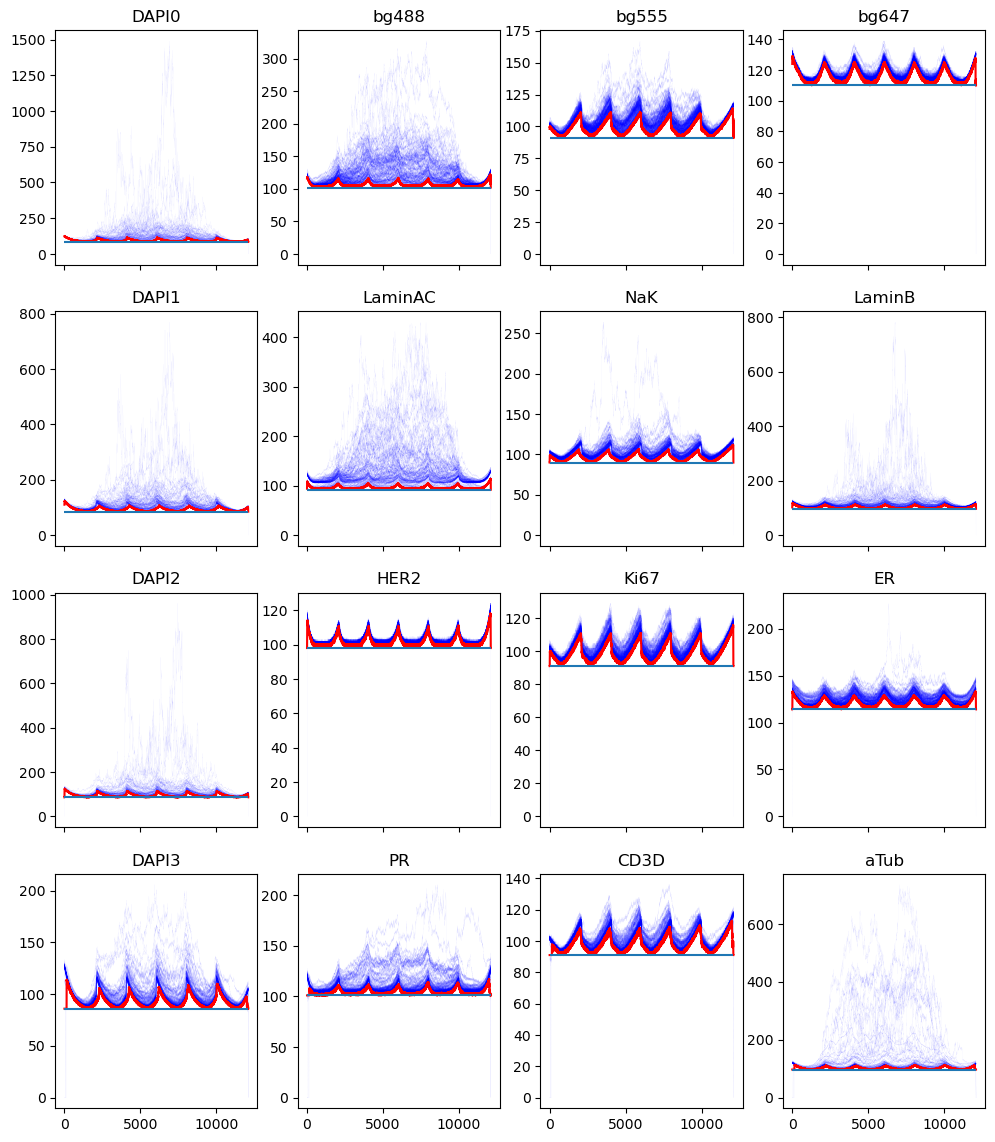

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,14), sharex=True, sharey=False)
for i, ax in enumerate(axes.ravel()):
    for j in range(len(horiz)):
        ax.plot(horiz[j, i, :], alpha=0.2, linewidth=.05, c='blue')
    ax.plot(minplot_clip[i], c='red')
    ax.hlines(y = minline[i], xmin = 0, xmax = img_side)
    ax.set_title(markers[i])

hmm, interesting.. plot 5 (second of the second row) seems to have two clearly distinct groups (two separate groups of lines).. could it be a slide-dependent thing? Let's plot the two slides in different colors

(0.0, 431.0)

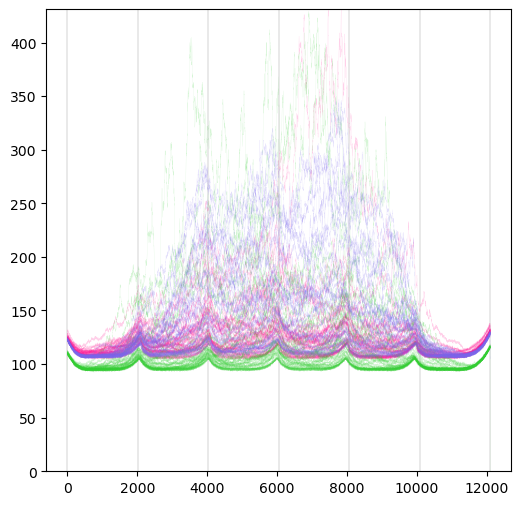

In [8]:
plt.figure(figsize=(6, 6))
for k in range(7):
    plt.vlines(x = 12096/6 * k, ymin = 0, ymax=horiz[:, i, :].max(), linewidth=0.2, color='black', alpha=0.6)
i = 5
for j in range(3):
    for k in range(ndots_cumulative[j], ndots_cumulative[j+1]):
        plt.plot(horiz[k, i, :], alpha=0.2, linewidth=.15, c=line_colors[j])
plt.ylim(horiz[:,i,:].min(), horiz[:,i,:].max())

Darn, it is. Looks like we better deal with the two slides separately in general... you never know. Let's repeat the first plot with this in mind:

In [9]:
selection = horiz[ndots_cumulative[j]:ndots_cumulative[j+1], i, :]

In [10]:
def distribution_min_clip(distribution, boundary=450):
    minplot = np.min([distribution[i]for i in range(np.shape(distribution)[1])] , axis=0) 
    minline = [np.min(x[boundary:-boundary]) for x in minplot]
    minplot_clip = [np.clip(x-y, a_min=0, a_max=255) for x,y in zip(minplot, minline)]

    return {'lower_bound': minplot, 'offset': minline, 'clipped_bound': minplot_clip}

horiz_background = [distribution_min_clip(horiz[ndots_cumulative[j]:ndots_cumulative[j+1]]) for j in range(3)]
vert_background = [distribution_min_clip(vert[ndots_cumulative[j]:ndots_cumulative[j+1]]) for j in range(3)]


In [15]:
slide = '525'
dot = '15'
filenames = list_subdir_filter(md.folders['stitched'], True, f'slide{slide}_.*_dot{dot}\.ome\.tif')
raws = np.array([tiff.imread(r) for r in filenames])
raws = np.reshape(raws, tuple((-1, *np.shape(raws)[-2:])))

In [36]:
ww = [raws[i] - horiz_background[0]['clipped_bound'][i] for i in range(len(raws))]

(-0.5, 12095.5, 12095.5, -0.5)

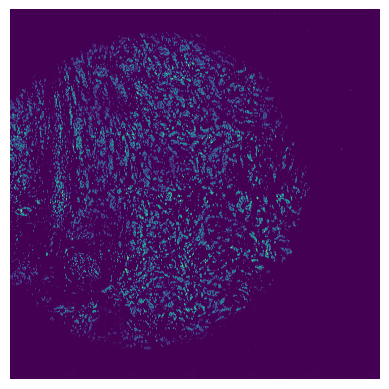

In [38]:
plt.imshow(local_normalization(ww[i]))
plt.axis('off')

(-0.5, 12095.5, 12095.5, -0.5)

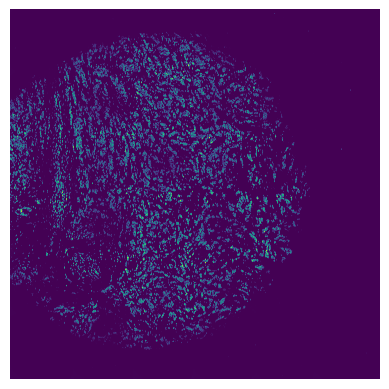

In [39]:
plt.imshow(local_normalization(raws[i]))
plt.axis('off')

In [42]:
corrected = [np.transpose(np.transpose(raws[i] - horiz_background[0]['offset'][i] - horiz_background[0]['clipped_bound'][i]) - vert_background[0]['clipped_bound'][i]) for i in range(len(raws))]

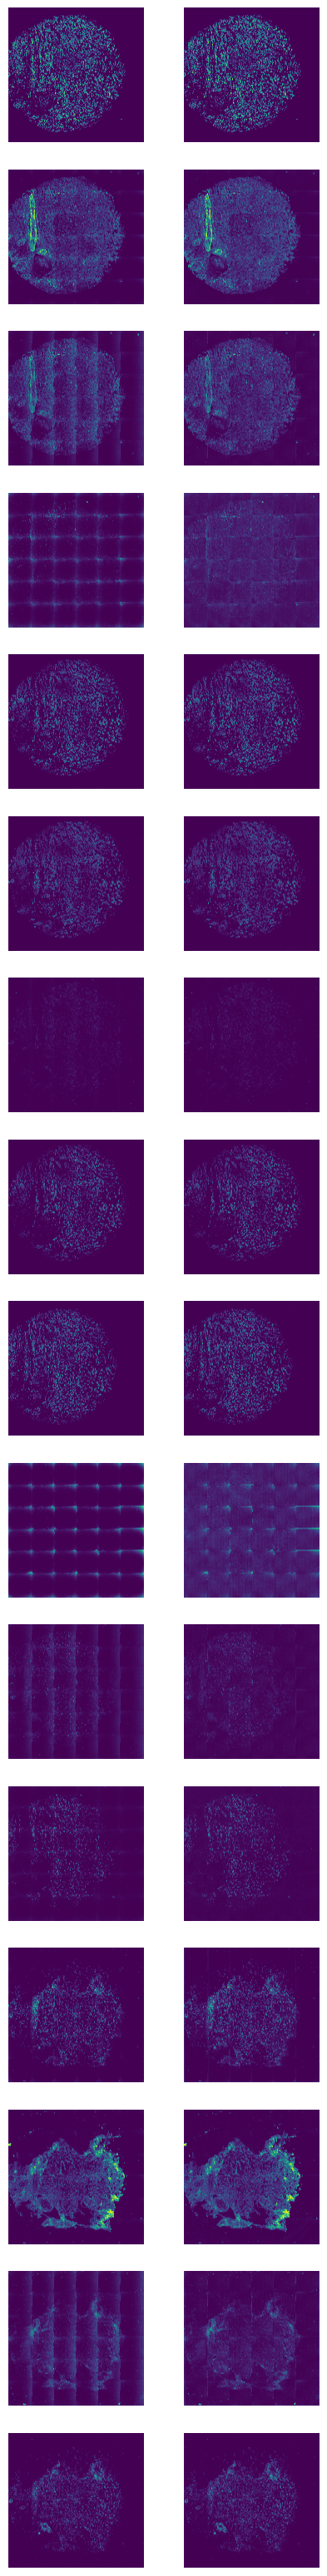

In [51]:
fig, axes = plt.subplots(nrows=16, ncols=2, figsize=(5,40), sharex=True, sharey=True)
for i in range(16):
    axes[i, 0].imshow(local_normalization(raws[i]))
    axes[i, 1].imshow(local_normalization(corrected[i]))
    for j in range(2):
        axes[i, j].axis('off')

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,14), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    for j in range(3):
        ax.plot(horiz_background[j]['clipped_bound'][i], alpha = .6, linewidth=.5, c=line_colors[j])
 #       ax.hlines(y = horiz_background[j]['offset'][i], xmin = 0, xmax = img_side, color=line_colors[j])
    ax.set_title(markers[i])
#plt.ylim(80,140)

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,14), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    ax.imshow(np.transpose(np.transpose(raws[i] - minplot_clip_slide[0][i])  - minplot_clip_slide[0][i]), vmax=255)
    ax.set_title(markers[i])

        
    #ax.hlines(y=250)

In [ ]:
corrected_h = np.array([raws[i] - horiz_background[0]['clipped_bound'][i] for i in range(len(raws))])

In [ ]:
mu = 10
sigma = mu/2.2
x = np.linspace(0, 2 * mu, 2 * mu)
gauss = norm.pdf(x, mu, sigma)
gauss = gauss / max(gauss)
# plt.plot(gauss)

In [ ]:
plt.plot(np.rollaxis(np.median(corrected_v, axis=0), axis=0))

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,14), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    for j in range(len(horiz)):
        ax.plot(horiz[j, i, :], alpha=0.4, linewidth=.05, c='blue')

plt.ylim(50,250)

In [ ]:
plt.figure(figsize=(20,20))
for k in range(7):
    plt.vlines(x = 12096/6 * k, ymin = 0, ymax=horiz[:, i, :].max(), linewidth=0.2, color='black', alpha=0.6)
i = 12
for j in range(md.slides_ndots['525']):
    plt.plot(horiz[j, i, :], alpha=0.2, linewidth=.15, c='blue')
for j in range(md.slides_ndots['525'], len(horiz)):
    plt.plot(horiz[j, i, :], alpha=0.2, linewidth=.15, c='red')

plt.ylim(horiz[:,i,:].min(), horiz[:,i,:].max())


In [ ]:
pickle.load(open(list_subdir_filter(out, False, 'profiles')[0], 'rb'))
list_subdir_filter(out, False, 'profiles')[0]

In [ ]:
slide = '525'
dot = '15'
filenames = list_subdir_filter(md.folders['stitched'], True, f'slide{slide}_.*_dot{dot}\.ome\.tif')
raws = np.array([tiff.imread(r) for r in filenames])
raws = np.reshape(raws, tuple((-1, *np.shape(raws)[-2:])))

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(np.squeeze(local_normalization(raws[11])))

In [ ]:
cle.gaussian_blur?

In [ ]:
%%time
filtered_image = cle.top_hat_sphere(cle.gaussian_blur(raws[9, :5000, :5000], sigma_x=5, sigma_y=5), radius_x=150, radius_y=150)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(local_normalization(filtered_image)[0])

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(local_normalization(raws[9, :5000, :5000])[0])

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(local_normalization(cle.gaussian_blur(raws[9, :5000, :5000], sigma_x=5, sigma_y=5) - np.array(filtered_image))[0])

In [ ]:
plt.imshow(raws[11, 4000:8000, 4000:8000] - np.array(filtered_image).astype('uint8'))

In [ ]:
def transpose_clean_transpose(array):
    horiz = np.median(array, axis=-2)
    first_sub = np.transpose(array - horiz)
    return np.trasnpose(first_sub - np.median(first_sub, axis=-2))

In [ ]:
%%time
rr2 = restoration.rolling_ball(raws[9, 3000:4500, 3000:4500], radius=500)

In [ ]:
plt.imshow(raws[9, 3000:4500, 3000:4500], cmap='gray', vmax=255)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(np.squeeze(local_normalization(rr)))
plt.axis('off')

In [ ]:
# tt_whole = pd.read_pickle(os.path.join(md.folders['clustering'], 'clustering_dataframe.pickle'))
# tt = tt_whole.copy()

# tt = tt.loc[(tt['slide'] == slide) & (tt['dot'].isin(dots))]
# tt['label'] = tt['label'].astype(int)

In [ ]:
n_channels = []
for marker in ['ER', 'PR', 'Ki67']:
    n_channels.append(np.where(np.array(md.markers[md.slides_version[slide]]) == marker)[0][0])

In [ ]:
md.folders

In [ ]:
os.path.join(out, re.sub('\.ome\.tif', '.pickle', os.path.basename(rawfile)))

In [ ]:
# read all tifs one by one, extract the horiz/vert profile of each channel, save it as a... pickle?

for rawfile in list_subdir_filter(md.folders['stitched'], True, f'slide{slide}_.*\.ome\.tif'):
    raw = tiff.imread(rawfile)
    
    os.path.join(out, re.sub('\.ome\.tif', '.pickle', os.path.basename(rawfile)))

In [ ]:
#all_raws = np.array([list_subdir_filter(md.folders['stitched'], True, f'slide{slide}_.*dot{dot}') for dot in dots]).flatten()
all_raws = np.array([list_subdir_filter(md.folders['stitched'], True, f'slide{slide}_cycle00')])
rawss = [tiff.imread(x) for x in all_raws]
raws = np.reshape(rawss, [-1] + list(np.shape(rawss)[-2:]))

In [ ]:
np.shape(raws)

In [ ]:
fig = plt.figure(figsize=(15,15))
plt.imshow(local_normalization(raws[2])[0])
plt.axis('off')

In [ ]:
mu = 100
sigma = mu/2.2
x = np.linspace(0, 2 * mu, 2 * mu)
gauss = norm.pdf(x, mu, sigma)
gauss = gauss / max(gauss)
plt.plot(gauss)

In [ ]:
def extract_profile(image, axis, q_index=0.9):
    raw_profile = np.quantile(image, q=q_index, axis=axis)
    clipped_profile = np.clip(raw_profile, *np.quantile(raw_profile, q=[0.02, 0.99]))
    return(clipped_profile)



horiz = [extract_profile(i, axis=0) for i in raws]
vert = [extract_profile(i, axis=1) for i in raws] #extract_profile(image, axis=1)
